In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time

from google.colab import files
import numpy as np
import pandas as pd
import itertools
import io
import timeit
import time

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
#%tensorflow_version 2.x
#import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1rJUCyDztqA321Uo690atZCQYS8Q1Y6XN"})
downloaded.GetContentFile('preprocessed_data.csv')
data_ready = pd.read_csv('preprocessed_data.csv')

In [3]:
def create_cnn_model(embedding_dim=50, n_filters=64, k_size=5, nlayers=1, nclass=3):
    model = Sequential(name="Convolutional_Neural_Network")
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    if nlayers > 4:
      model.add(layers.Conv1D(filters = n_filters*3, kernel_size = k_size*3, activation='relu', name = "quinto"))
      model.add(layers.Conv1D(filters = n_filters*3, kernel_size = k_size*3, activation='relu', name = "quarto"))
    if nlayers > 2:
      model.add(layers.Conv1D(filters = n_filters*2, kernel_size = k_size*2, activation='relu', name = "terzo"))
      model.add(layers.Conv1D(filters = n_filters*2, kernel_size = k_size*2, activation='relu', name = "secondo"))
    model.add(layers.Conv1D(filters = n_filters, kernel_size = k_size, activation='relu', name='primo'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(nclass, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# define the grid search parameters
cand_bs = [512, 2048] #batch size
cand_ed = [50, 100, 200] #dimension of output of embedding layer
cand_nf = [16, 32] #number of filters convolutional layer
cand_ks = [3, 5] #kernel size convolutional layer
cand_nl = [1, 3, 5] #number of convolutional layers
#OTHER HYPERPARAMETERS TO OPTIMIZE: Number of convolutional layers, kernel dimension

In [ ]:
par = ['Batch size', 'Embedding layer output', 'Num conv. filters', 'Kernel size','Num conv. layers']
val = ['512, 2048', '50, 100, 200', '16, 32', '3, 5', '1, 3, 5']

d = {'Parametro': par, 'Valori possibili': val}
hyperp_grid = pd.DataFrame(d)

hyperp_grid.to_csv('hyperp_grid.csv', encoding = 'utf-8-sig') 
files.download('hyperp_grid.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [6]:
select_data = data_ready[data_ready['category'].isin(cat_index[0:3])].dropna().reset_index(drop=True)
print(select_data['category'].value_counts())

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"], random_state = 1000,
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_ready['clean_text'][:100])

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = np.array([len(a) for a in X_train]).max()

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

model = KerasClassifier(build_fn=create_cnn_model, epochs=25, verbose=0, nclass=3)

hep-ph      50603
quant-ph    44678
hep-th      39013
Name: category, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Set 0

In [ ]:
#1 conv layer

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[:1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results0 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#3 conv layers

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[1:2])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results1 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
#5 conv layers

param_grid = dict(batch_size=cand_bs, embedding_dim=cand_ed, n_filters=cand_nf, k_size=cand_ks, nlayers=cand_nl[2:3])
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=3, n_jobs=1, cv=5)

grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results2 = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')

In [ ]:
cv_results = pd.concat([cv_results0, cv_results1, cv_results2]).sort_values(by=['mean_test_score'], ascending=False).reset_index(drop=True)

emb_cv_results0 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(emb_cv_results0.columns.values)
cv_results_set0_emb = emb_cv_results0[clist[-2:] + clist[:-2]]
cv_results_set0_emb

In [ ]:
cv_results_set0_emb.to_csv('cv_results_set0_emb.csv', encoding = 'utf-8-sig') 
files.download('cv_results_set0_emb.csv')

In [ ]:
clear_session()
model = create_cnn_model(embedding_dim=50, n_filters=16, k_size=8, nlayers=1, nclass=3)
model.summary()

Model: "Convolutional_Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 194, 50)           92400     
                                                                 
 primo (Conv1D)              (None, 187, 16)           6416      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 99,019
Trainable params: 99,019
Non-trainable params: 0
__________________________________

In [ ]:
history = model.fit(X_train, dummy_y_train, epochs=50, verbose=True, validation_data=(X_test, dummy_y_test), batch_size=4096)

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Training Accuracy: 0.9988
Testing Accuracy:  0.9307


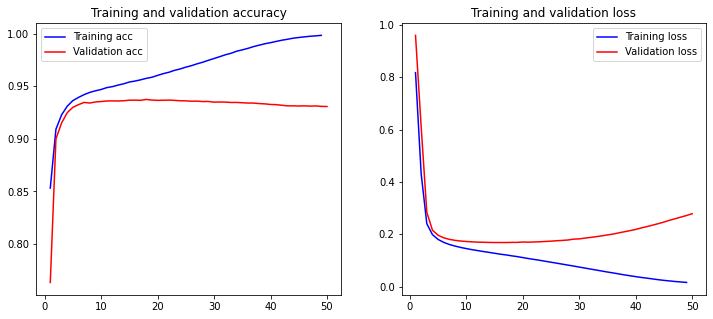

In [ ]:
plot_history(history)

Set 1